In [49]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing_extensions import Annotated
import operator

In [50]:
load_dotenv()
model = ChatOpenAI(model="gpt-4o-mini")

In [51]:
class EvaluationSchema(BaseModel):

    feedback: str = Field(description="Detailed feedback on the essay")
    score : int = Field(description="Score out of 10", ge=0, le=10)
    
    

In [52]:
structured_modal = model.with_structured_output(EvaluationSchema)

In [53]:
essay = """The COVID-19 pandemic has had a profound impact on global health, economies, and societies. It has exposed vulnerabilities in healthcare systems, highlighted the importance of public health infrastructure, and accelerated the adoption of digital technologies. The pandemic has also underscored the need for international cooperation in addressing global health crises. As we move forward, it is crucial to learn from the experiences of the pandemic to build more resilient systems that can better respond to future health emergencies."""

In [54]:
prompt = f"Provide a detailed feedback and score out of 10 for the following essay: {essay}"
result = structured_modal.invoke(prompt)

In [55]:
result.score

7

In [56]:
class UpscState(TypedDict):
    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_score: int
    individual_scores: Annotated[list[int], operator.add]
    average_score: float


In [57]:
def evaluate_language(state: UpscState) -> UpscState:
    
    prompt = f"Evaluate the following essay for language quality, grammar, and coherence. Provide detailed feedback and a score out of 10.\n\nEssay: {state['essay']}"
    result = structured_modal.invoke(prompt)
    
    return {"language_feedback": result.feedback, "individual_scores": [result.score]}

In [58]:
def evaluate_analysis(state: UpscState) -> UpscState:

    prompt = f"Evaluate the following essay for analytical depth, argument strength, and use of evidence. Provide detailed feedback and a score out of 10.\n\nEssay: {state['essay']}"
    result = structured_modal.invoke(prompt)

    return {"analysis_feedback": result.feedback, "individual_scores": [result.score]}

In [59]:
def evaluate_clarity(state: UpscState) -> UpscState:

    prompt = f"Evaluate the following essay for clarity of expression, organization of ideas, and overall readability. Provide detailed feedback and a score out of 10.\n\nEssay: {state['essay']}"
    result = structured_modal.invoke(prompt)

    return {"clarity_feedback": result.feedback, "individual_scores": [result.score]}

In [65]:
def final_evaluation(state: UpscState) -> UpscState:

    prompt = f"Based on the following individual feedbacks and scores, provide an overall evaluation of the essay. Summarize the strengths and weaknesses, and provide an overall score out of 10.\n\nLanguage Feedback: {state['language_feedback']}\nAnalysis Feedback: {state['analysis_feedback']}\nClarity Feedback: {state['clarity_feedback']}\nIndividual Scores: {state['individual_scores']}"
    
    overall_score = model.invoke(prompt)
    
    #avage calculate average score
    average_score = sum(state['individual_scores']) / len(state['individual_scores'])
    
    return {"overall_score": overall_score, "average_score": average_score}

In [66]:
graph = StateGraph(UpscState)

graph.add_node('evaluate_language', evaluate_language)
graph.add_node('evaluate_analysis', evaluate_analysis)
graph.add_node('evaluate_clarity', evaluate_clarity)   
graph.add_node('final_evaluation', final_evaluation)


#edge
graph.add_edge(START, 'evaluate_language')
graph.add_edge(START, 'evaluate_analysis')
graph.add_edge(START, 'evaluate_clarity')

graph.add_edge('evaluate_analysis', 'final_evaluation')
graph.add_edge('evaluate_language', 'final_evaluation')
graph.add_edge('evaluate_clarity', 'final_evaluation')
graph.add_edge('final_evaluation', END)

workflow = graph.compile()


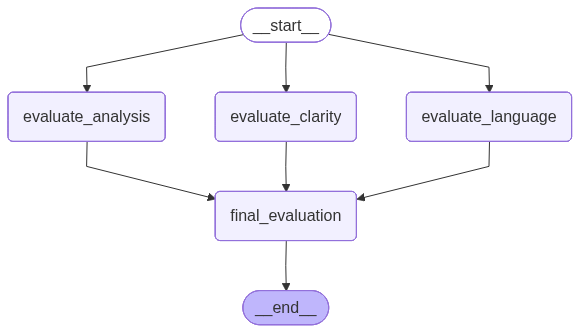

In [67]:
workflow

In [68]:
initial_state = {
    "essay": essay
}

workflow.invoke(initial_state)


{'essay': 'The COVID-19 pandemic has had a profound impact on global health, economies, and societies. It has exposed vulnerabilities in healthcare systems, highlighted the importance of public health infrastructure, and accelerated the adoption of digital technologies. The pandemic has also underscored the need for international cooperation in addressing global health crises. As we move forward, it is crucial to learn from the experiences of the pandemic to build more resilient systems that can better respond to future health emergencies.',
 'language_feedback': "The essay effectively communicates the significant impacts of the COVID-19 pandemic across various sectors, including health, economies, and societies. The language used is clear and formal, appropriate for an informative essay. The grammatical structure is correct throughout, with no evident errors. The transitions between ideas are smooth, enhancing the overall coherence of the text. However, the essay could benefit from mo